### $5$-QUBIT CODE UNDER RANDOM PAULI ERROR

In this project, we create a function that takes as input $x \in \mathbb{F}_2^n$, and an error probability $p \in (0,1)$. The function quantum circuit that prepares the logical state, $\Ket{x_L}$, for the 5-qubit code, and runs it through a random Pauli error channel, with error rate $p$ (for each qubit), measures syndromes, applies the recovery operations, and measures the data qubits. We define the success probabilty to be the probabilty that a component of $\Ket{x_L}$ is measured at the end. We then visualize the dependence of the success probability for various values of p. 

In [37]:
%pip install qiskit qiskit_aer pylatexenc

Note: you may need to restart the kernel to use updated packages.


### The $5$-qubit code. 

The $5$-qubit code is a stabilizer code defined by the stabilizer group $\langle P_1, P_2, P_3, P_4 \rangle$, where $P_1=XZZX 1,P_2=XZZX,P_3=X1XZZ,P_4=ZX1XZ$. 

In [38]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np

### The syndrome measurement circuit. 

We design a circuit that gets the four syndromes for the $5$-qubit code, using measurement. 

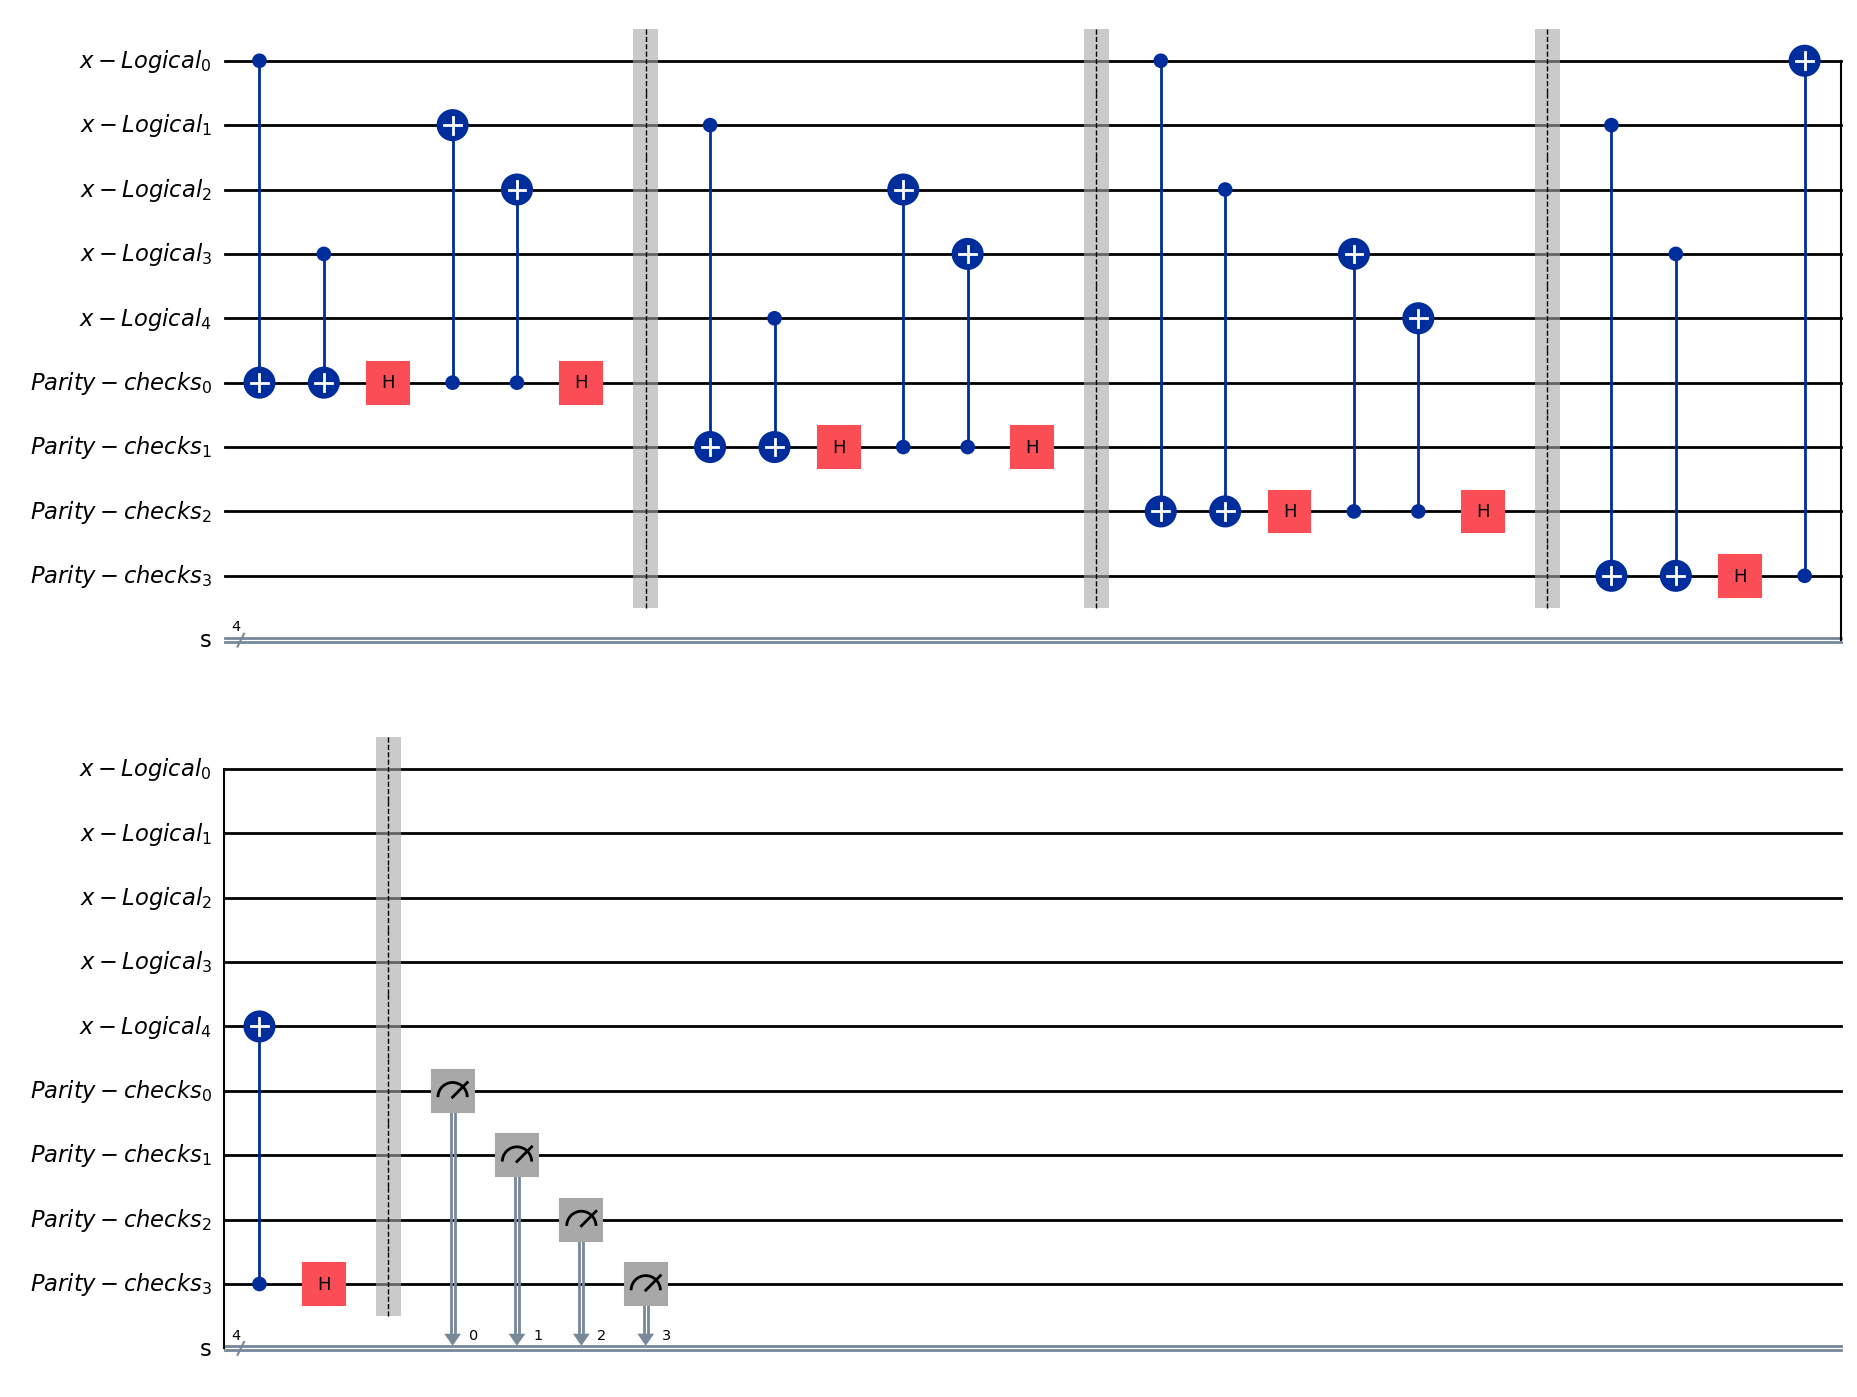

In [81]:
data_register=QuantumRegister(size=5, name="x-Logical")
check_register=QuantumRegister(size=4, name="Parity-checks")
code_circuit=QuantumCircuit(data_register, check_register)

# Extract syndrome for P_1
code_circuit.cx(data_register[0], check_register[0])
code_circuit.cx(data_register[3], check_register[0])
code_circuit.h(check_register[0])
code_circuit.cx(check_register[0], data_register[1])
code_circuit.cx(check_register[0], data_register[2])
code_circuit.h(check_register[0])
code_circuit.barrier()

# Extract syndrome for P_2
code_circuit.cx(data_register[1], check_register[1])
code_circuit.cx(data_register[4], check_register[1])
code_circuit.h(check_register[1])
code_circuit.cx(check_register[1], data_register[2])
code_circuit.cx(check_register[1], data_register[3])
code_circuit.h(check_register[1])
code_circuit.barrier()

# Extract syndrome for P_3
code_circuit.cx(data_register[0], check_register[2])
code_circuit.cx(data_register[2], check_register[2])
code_circuit.h(check_register[2])
code_circuit.cx(check_register[2], data_register[3])
code_circuit.cx(check_register[2], data_register[4])
code_circuit.h(check_register[2])
code_circuit.barrier()

# Extract syndrome for P_4
code_circuit.cx(data_register[1], check_register[3])
code_circuit.cx(data_register[3], check_register[3])
code_circuit.h(check_register[3])
code_circuit.cx(check_register[3], data_register[0])
code_circuit.cx(check_register[3], data_register[4])
code_circuit.h(check_register[3])
code_circuit.barrier()

#Measure syndromes
syndromes = ClassicalRegister(size=4, name="s")
code_circuit.add_register(syndromes)
# measure
code_circuit.measure(check_register, syndromes)
code_circuit.draw(output="mpl")

### fixing errors

We now add fixes to the circuit depending on what the measuements are. The following are the syndromes for each possible single qubit error. 

| **Single qubit error** | **Syndrome** | **number**|
|------------------------|---------------|----------|
| X[0]                   | 1001          |  9       |
| X[1]                   | 0010          |  2       |
| X[2]                   | 0101          |  5       |
| X[3]                   | 1010          |  10      |
| X[4]                   | 0100          |  4       |
| Z[0]                   | 0110          |  6       |
| Z[1]                   | 1100          |  12      |
| Z[2]                   | 1000          |  8       |
| Z[3]                   | 0001          |  1       |
| Z[4]                   | 0011          |  3       |
| Y[0]                   | 1111          |  15      |
| Y[1]                   | 1110          |  14      |
| Y[2]                   | 1101          |  13      |
| Y[3]                   | 1011          |  11      |
| Y[4]                   | 0111          |  7       |




In [40]:
with code_circuit.if_test((syndromes,9)):
    code_circuit.x(data_register[0])
with code_circuit.if_test((syndromes,2)):
    code_circuit.x(data_register[1])
with code_circuit.if_test((syndromes,5)):
    code_circuit.x(data_register[2])
with code_circuit.if_test((syndromes,10)):
    code_circuit.x(data_register[3])
with code_circuit.if_test((syndromes,4)):
    code_circuit.x(data_register[4])
with code_circuit.if_test((syndromes,6)):
    code_circuit.z(data_register[0])
with code_circuit.if_test((syndromes,12)):
    code_circuit.z(data_register[1])
with code_circuit.if_test((syndromes,8)):
    code_circuit.z(data_register[2])
with code_circuit.if_test((syndromes,1)):
    code_circuit.z(data_register[3])
with code_circuit.if_test((syndromes,3)):
    code_circuit.z(data_register[4])
with code_circuit.if_test((syndromes,15)):
    code_circuit.y(data_register[0])
with code_circuit.if_test((syndromes,14)):
    code_circuit.y(data_register[1])
with code_circuit.if_test((syndromes,13)):
    code_circuit.y(data_register[2])
with code_circuit.if_test((syndromes,11)):
    code_circuit.y(data_register[3])
with code_circuit.if_test((syndromes,7)):
    code_circuit.y(data_register[4])

### Preparing the logical $0$ and $1$ states. 

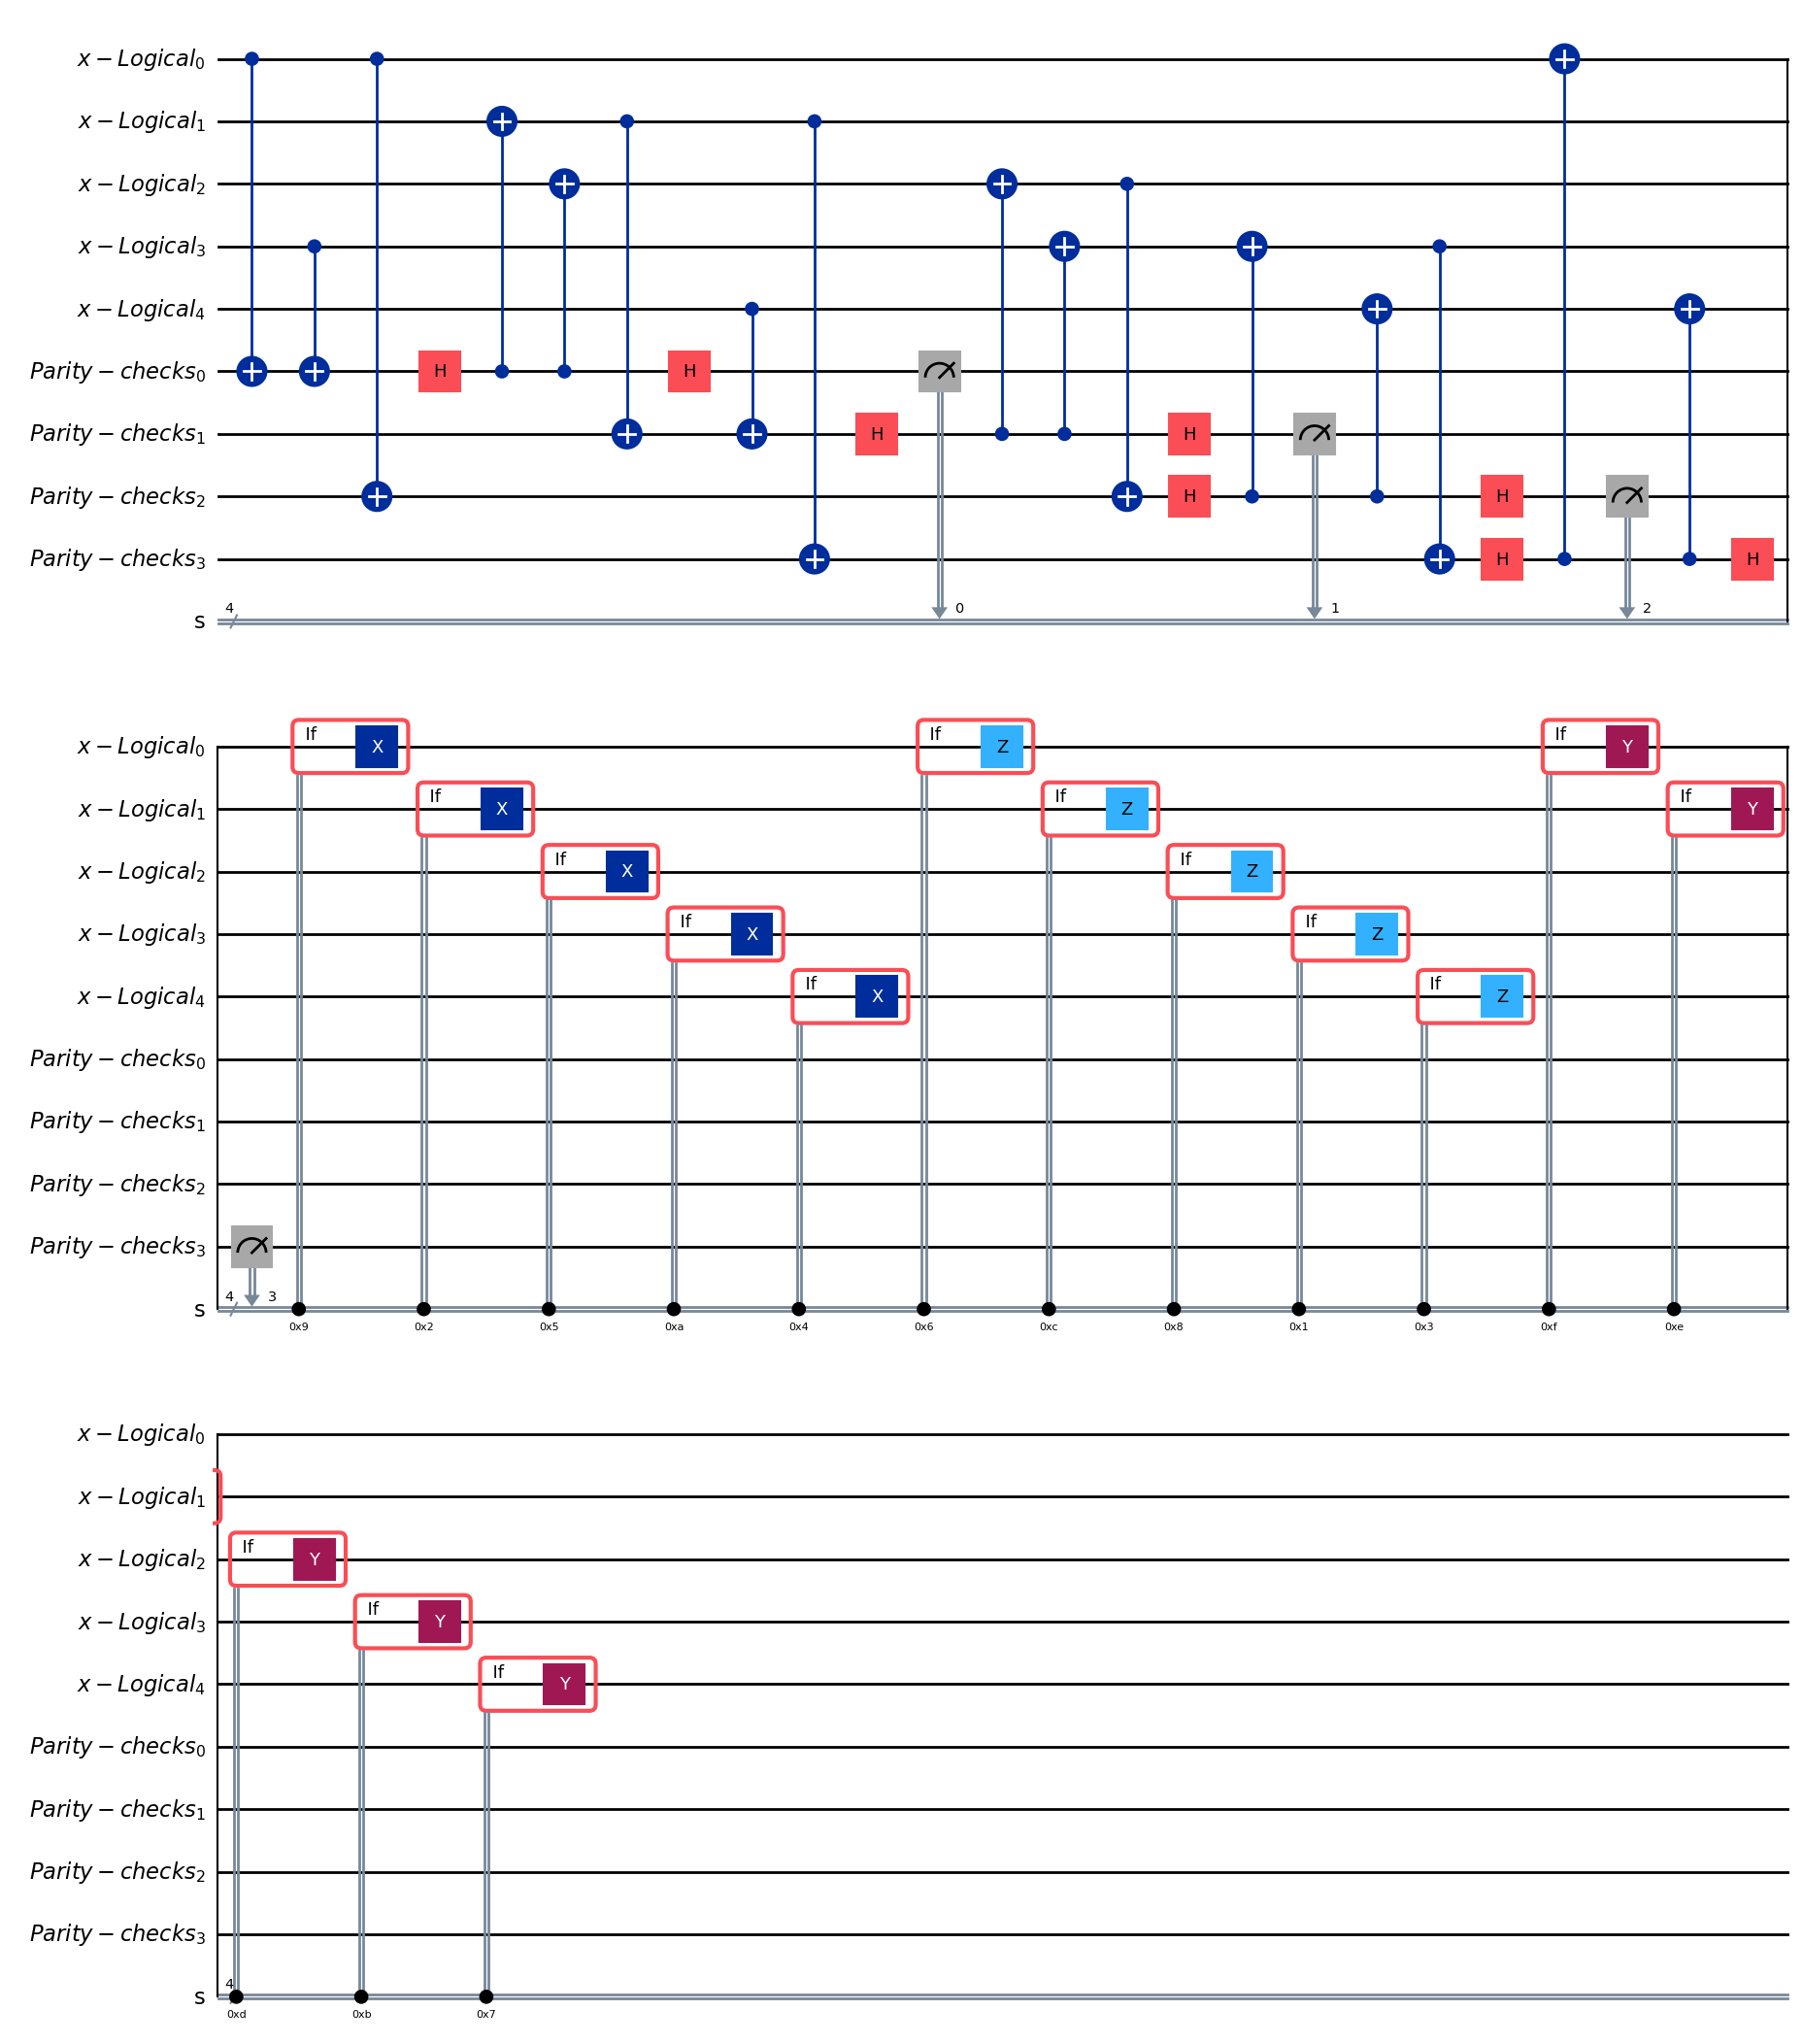

In [41]:
code_circuit.draw(output="mpl")

### The state preparation circuit

We need to implement a circuit that takes 

$$
\Ket{0_L} = \frac{1}{4} \Big(
\Ket{00000} + \Ket{10010} + \Ket{01001} + \Ket{10100} + \Ket{01010} 
- \Ket{11011} - \Ket{00110} - \Ket{11000} \\
- \Ket{11101} - \Ket{00011} - \Ket{11110} - \Ket{01111} 
- \Ket{10001} - \Ket{01100} - \Ket{10111} + \Ket{00101}
\Big)
$$

$$
\Ket{1_L} = \frac{1}{4} \Big(
\Ket{11111} + \Ket{01101} + \Ket{10110} + \Ket{01011} + \Ket{10101} 
- \Ket{00100} - \Ket{11001} - \Ket{00111} \\
- \Ket{00010} - \Ket{11100} - \Ket{00001} - \Ket{10000} 
- \Ket{01110} - \Ket{10011} - \Ket{01000} + \Ket{11010}
\Big)
$$


In [42]:
from qiskit.quantum_info import Statevector

# Define basis states as numbers

#bitstrings = [
#    '00000', '01001', '10010', '00101', '01010',
#    '11011', '01100', '00011', '10111', '11000',
#    '01111', '11110', '10001', '00110', '11101', '10100'
#]
bitstrings = [
    '00000', '10010', '01001', '10100', '01010',
    '11011', '00110', '11000', '11101', '00011',
    '11110', '01111', '10001', '01100', '10111', '00101'
]

# Define coefficients (signs)
signs = [1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1]

# Create statevector
N = 5
dim = 2 ** N
vec = np.zeros(dim, dtype=complex)

for bstring, sign in zip(bitstrings, signs):
    idx = int(bstring, 2)
    vec[idx] = sign

# Normalize
vec /= 4

logical_ket0_vector = [
        1 / 4,
        0,
        0,
        1 / 4,
        0,
        -(1 / 4),
        1 / 4,
        0,
        0,
        -(1 / 4),
        -(1 / 4),
        0,
        1 / 4,
        0,
        0,
        -(1 / 4),
        0,
        1 / 4,
        -(1 / 4),
        0,
        -(1 / 4),
        0,
        0,
        -(1 / 4),
        1 / 4,
        0,
        0,
        -(1 / 4),
        0,
        -(1 / 4),
        -(1 / 4),
        0,
    ]

# Make a Qiskit statevector object
logical_zero = Statevector(logical_ket0_vector)

print(logical_zero)


Statevector([ 0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,
             -0.25+0.j,  0.25+0.j,  0.  +0.j,  0.  +0.j, -0.25+0.j,
             -0.25+0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,  0.  +0.j,
             -0.25+0.j,  0.  +0.j,  0.25+0.j, -0.25+0.j,  0.  +0.j,
             -0.25+0.j,  0.  +0.j,  0.  +0.j, -0.25+0.j,  0.25+0.j,
              0.  +0.j,  0.  +0.j, -0.25+0.j,  0.  +0.j, -0.25+0.j,
             -0.25+0.j,  0.  +0.j],
            dims=(2, 2, 2, 2, 2))


In [43]:
logical_zero.draw("Latex", max_size=120)

<IPython.core.display.Latex object>

### Running Logical zero through a random pauli channel with error p

In [44]:
def pauli_error(p):
    ## input :p
    ## output: the logical 0 state after passing through the pauli channel with error p (each register flips with probability p)
    data_register=QuantumRegister(size=5, name="x-Logical")
    circuit=QuantumCircuit(data_register)
    for i in range(5):
        rand_float=np.random.rand()
        if rand_float < p/3:
            circuit.x([i])
        elif rand_float < 2*p/3:
            circuit.y([i])
        elif rand_float < p:
            circuit.z([i])
    return circuit

### Putting it all together!

We create a correction circuit that first adds pauli errors to a state and then corrects them. 

In [79]:
def correction_circuit(p):
    data_register=QuantumRegister(size=5, name="x-Logical")
    check_register=QuantumRegister(size=4, name="Parity-checks")
    syndromes = ClassicalRegister(size=4, name="s")
    circuit=QuantumCircuit(data_register, check_register, syndromes)
    ## Add the logical 0 state at the front
    logical_qubits = [0, 1, 2, 3, 4]

    # Insert initialization at the front
    circuit.initialize(logical_zero.data, logical_qubits)

    
    ## Attach pauli error circuit
    circuit.compose(pauli_error(p), qubits=data_register, inplace=True)
    ## attach error correction circuit
    circuit.compose(code_circuit, inplace=True)
    ## Measure the data qubits
    output = ClassicalRegister(size=5, name="measurement")
    circuit.add_register(output)
    circuit.measure(data_register, output)
    return circuit

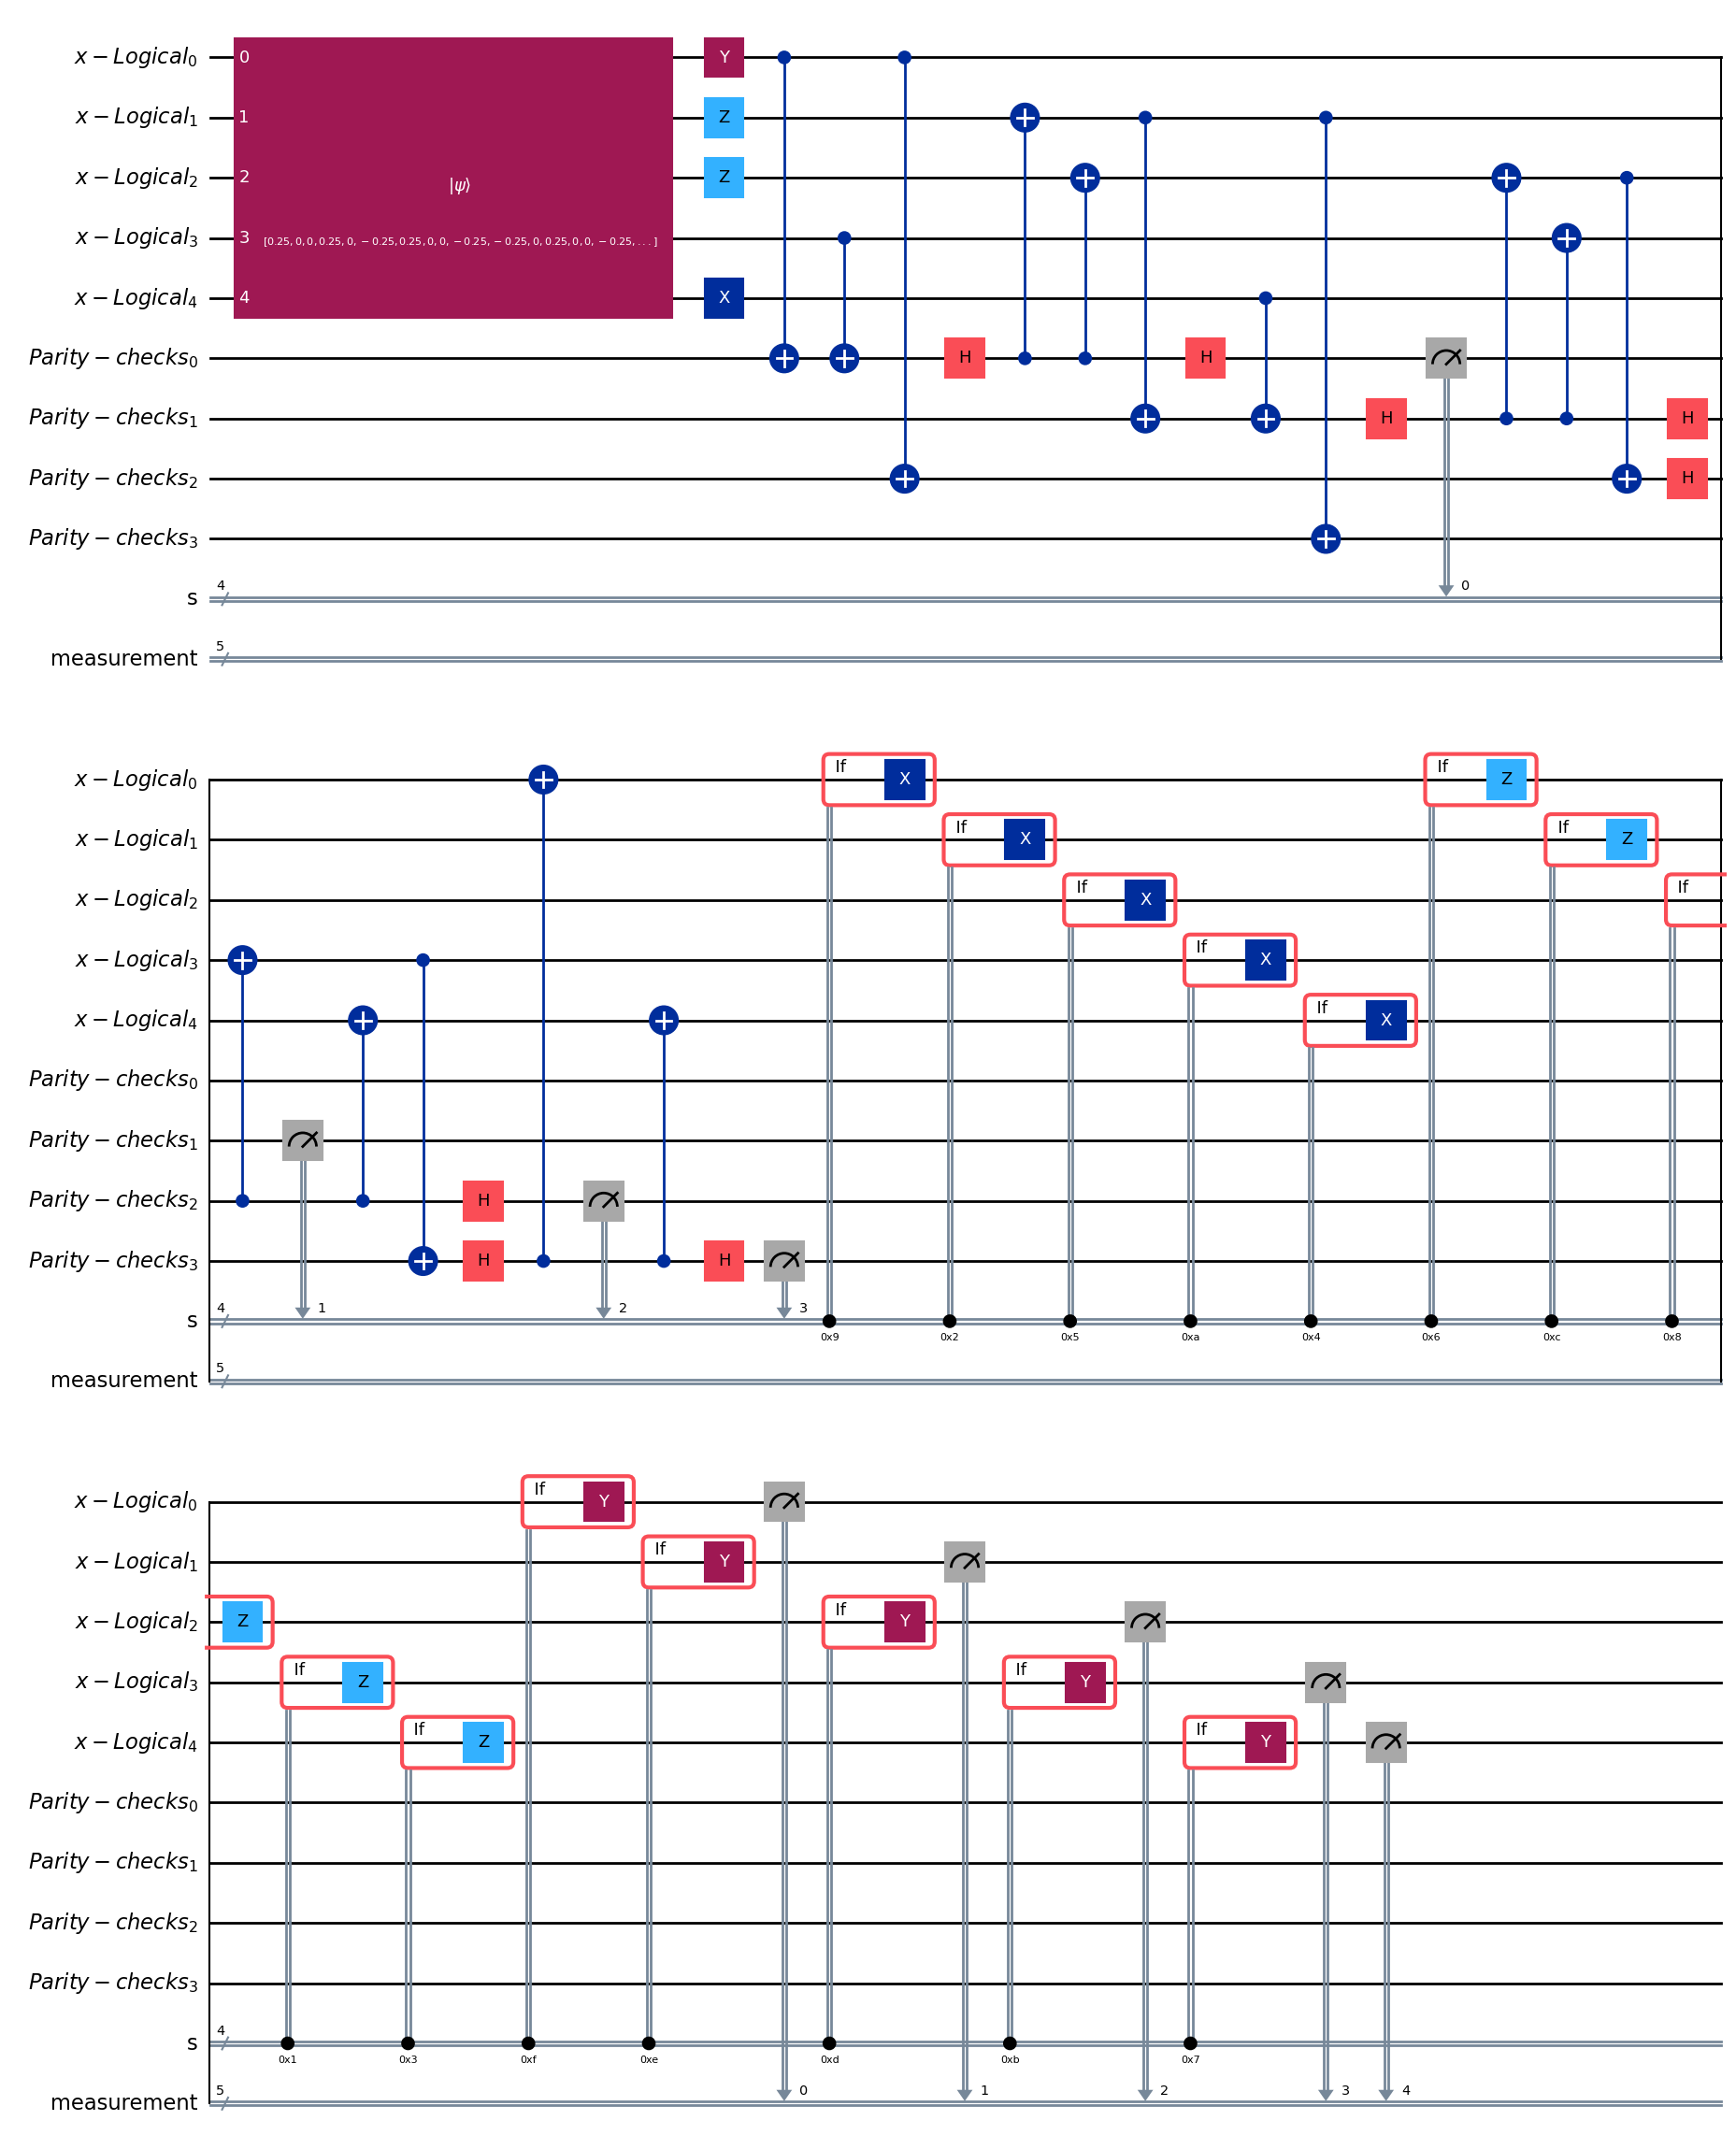

In [80]:
correction_circuit(0.5).draw(output="mpl")

### Final part: testing!

We run the circuit on the Logical $0$ we have earlier prepared and output true if the final state is same as the logical 0 state. 

In [91]:

from qiskit_aer import AerSimulator
import numpy as np

p = 0.25
qec_circuit = correction_circuit(p)

# --- Logical zero basis states ---
logical_zero_amplitudes = logical_zero.data
num_qubits = logical_zero.num_qubits

supported_bitstrings = []
for idx, amp in enumerate(logical_zero_amplitudes):
    if not np.isclose(amp, 0):
        bitstring = format(idx, f'0{num_qubits}b')[::-1]
        supported_bitstrings.append(bitstring)

print("Basis states in logical zero state:", supported_bitstrings)

# --- Run ---
simulator = AerSimulator()
shots = 200
compiled_circuit = transpile(qec_circuit, simulator)
job = simulator.run(compiled_circuit, shots=shots)  
result = job.result()
counts = result.get_counts()

# --- Safe parse ---
logical_zero_counts = 0
for key, freq in counts.items():
    parts = key.split()
    if len(parts) == 2:
        logical_bits, syndrome_bits = parts
    else:
        logical_bits = parts[1]
    if logical_bits in supported_bitstrings:
        logical_zero_counts += freq

prob_logical_zero_component = logical_zero_counts / shots

print(f"Probability of measuring a basis state supported by logical |0>: {prob_logical_zero_component:.6f}")


Basis states in logical zero state: ['00000', '11000', '10100', '01100', '10010', '01010', '00110', '11110', '10001', '01001', '00101', '11101', '00011', '11011', '10111', '01111']
Probability of measuring a basis state supported by logical |0>: 1.000000


### We document the results for different values of $p$:


| **p** | **Probabilisty of successful decoding** |
|---------------------|----------|
| 0                   | 1        |  
| 0.1                 |0010      | 
 


In [92]:
counts

{'01100 1100': 8,
 '10010 1100': 10,
 '10001 1100': 15,
 '11000 1100': 10,
 '10100 1100': 12,
 '11101 1100': 7,
 '11011 1100': 19,
 '10111 1100': 14,
 '11110 1100': 10,
 '00110 1100': 16,
 '01001 1100': 9,
 '01010 1100': 22,
 '01111 1100': 6,
 '00011 1100': 10,
 '00000 1100': 14,
 '00101 1100': 18}

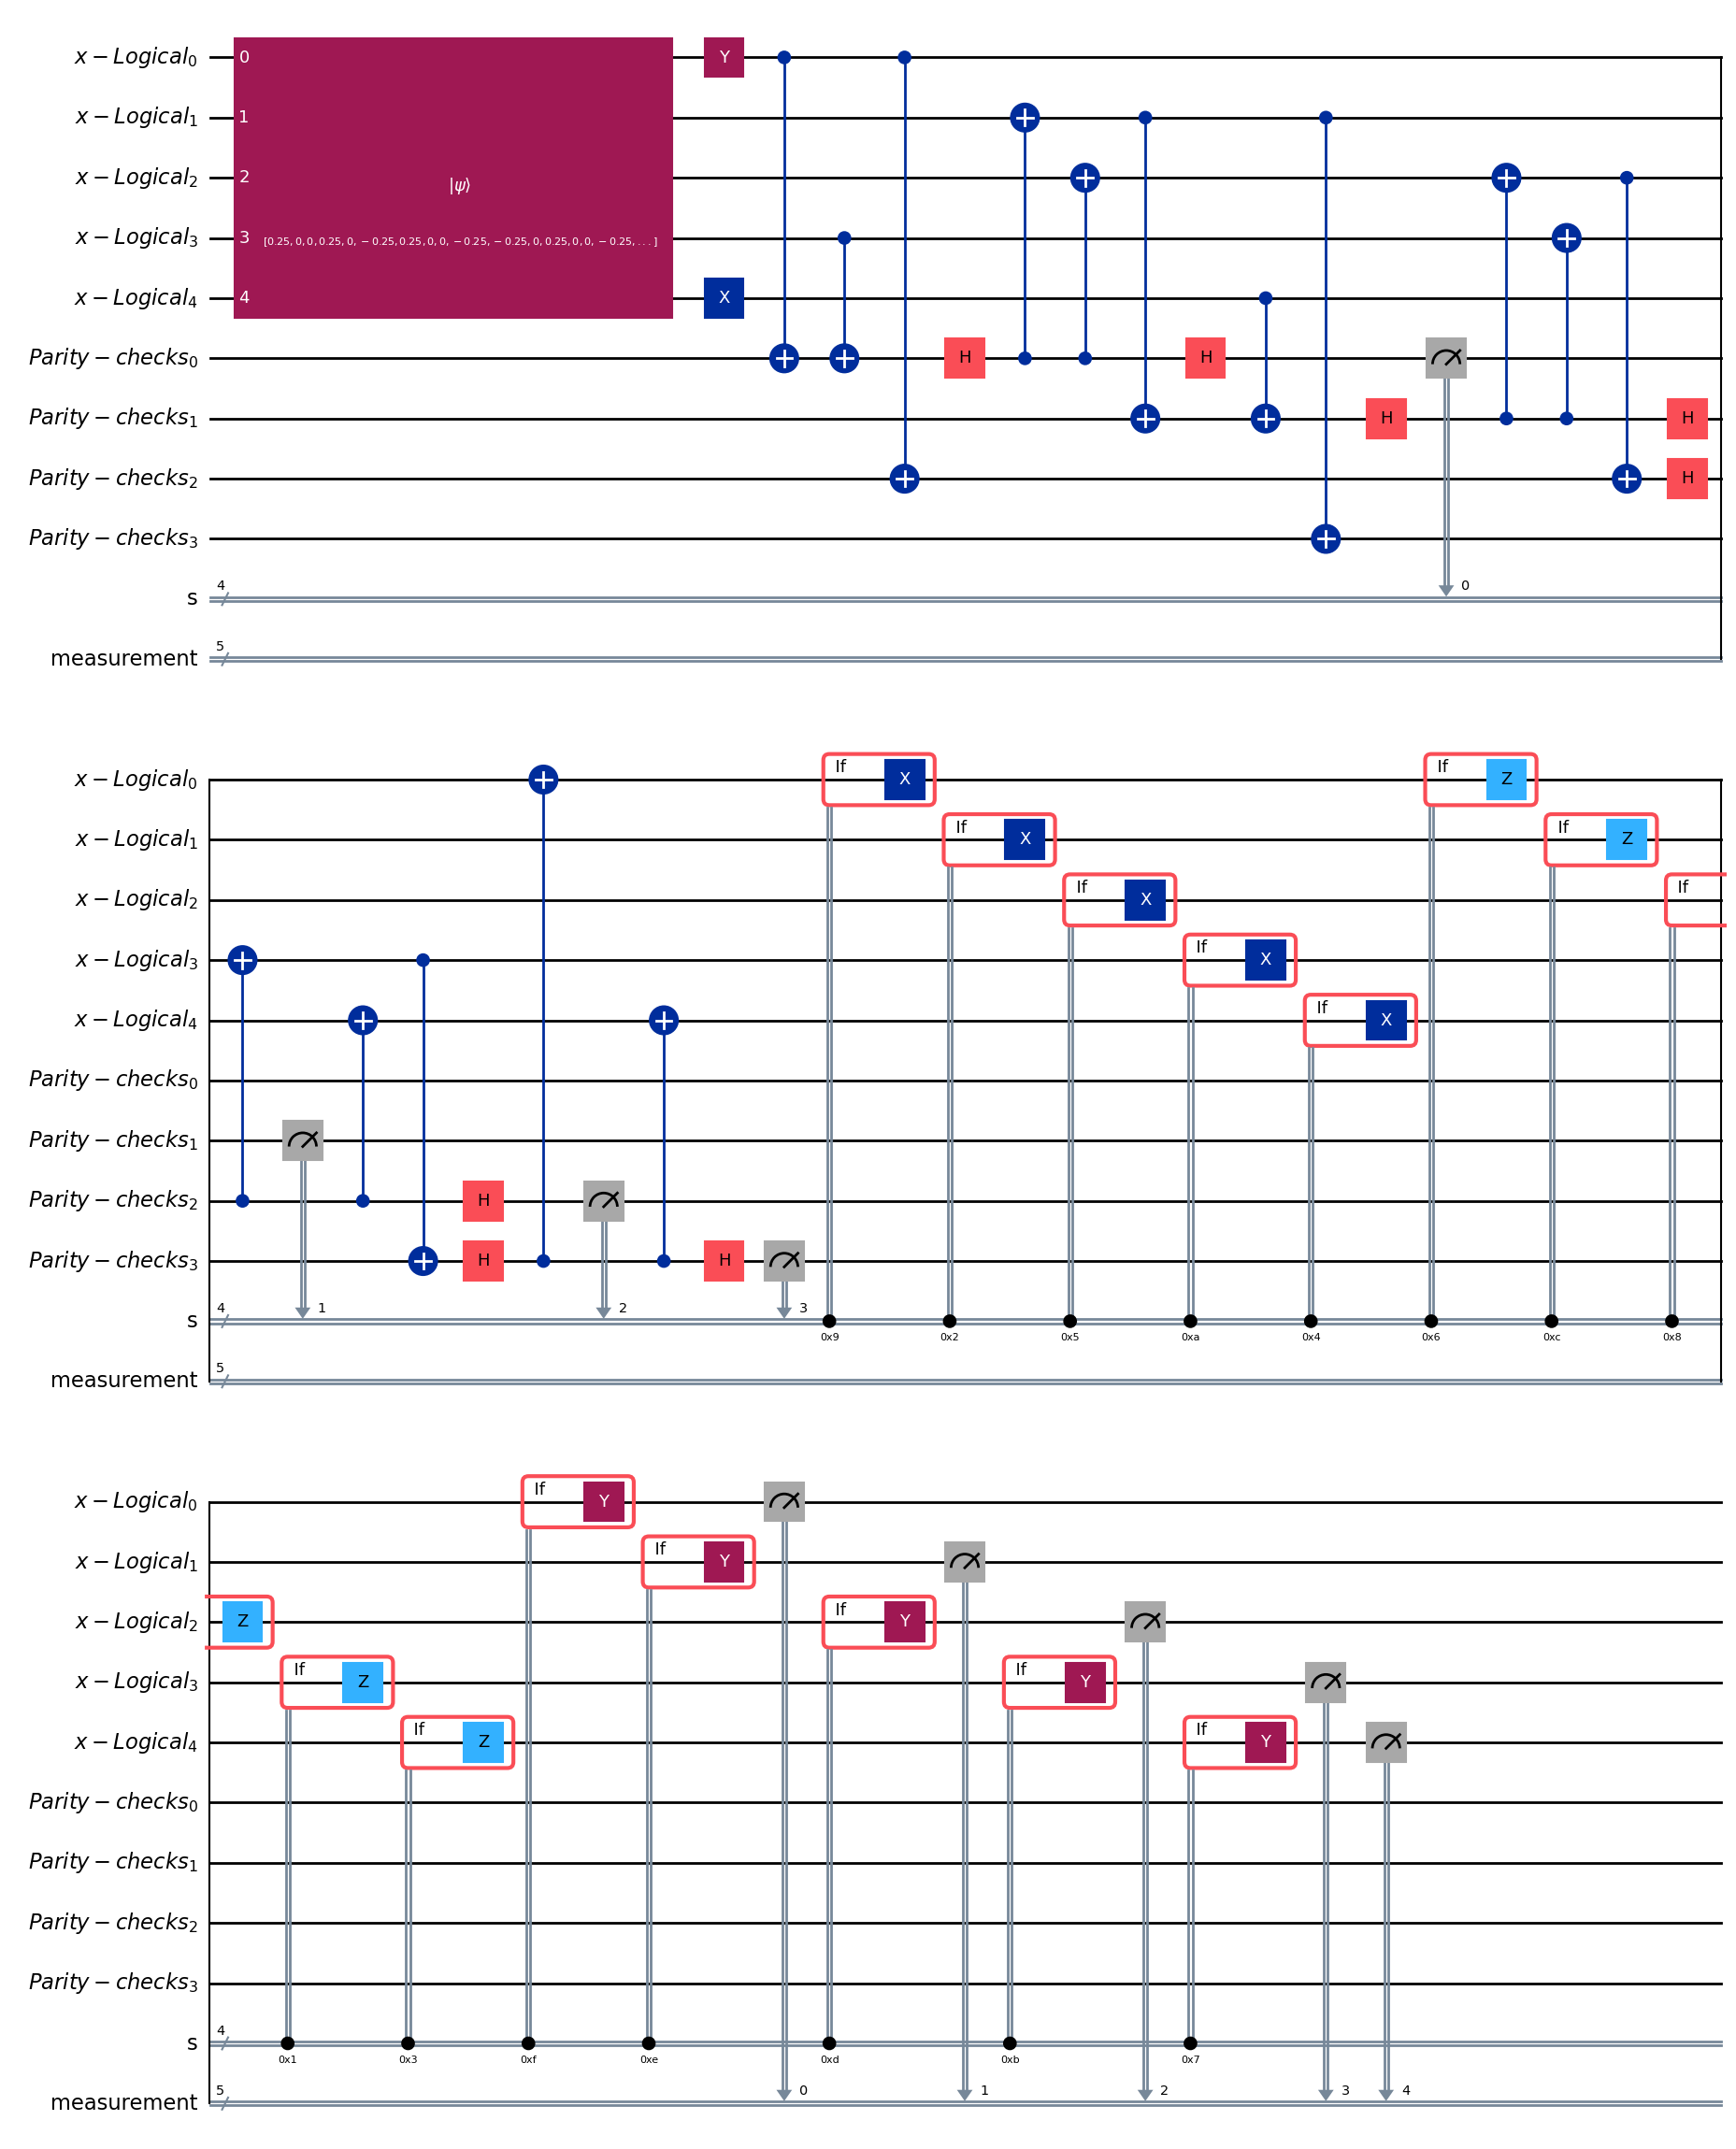

In [65]:
qec_circuit.draw(output="mpl")